In [1]:
from model_utils import *
from sklearn.utils import resample
import pandas as pd
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    validation_curve,
)
from sklearn import preprocessing

## Import Data
### Data used for preliminary results are downsampled and balanced

In [66]:
# import dataset
test_data = "dataset/test.csv"
df_test = pd.read_csv(test_data, sep=",", index_col="ID_code")

train_data = "dataset/train.csv"
df_train = pd.read_csv(train_data, sep=",", index_col="ID_code")

# Separate majority and minority classes
df2_majority = df_train[df_train["target"] == 0]
df2_minority = df_train[df_train["target"] == 1]
n_samples = df2_minority.target.sum()

df2_majority_downsampled = resample(
   df2_majority, replace=False, n_samples=n_samples, random_state=99
)
df_downsampled = pd.concat([df2_majority_downsampled, df2_minority])
X_dn = df_downsampled.drop(["target"], axis=1)
y_dn = df_downsampled["target"]

# calculatig the z-score normalization using sklearn
std_scale = preprocessing.StandardScaler().fit(df_train.drop(["target"], axis=1).values)
X_dn_norm = std_scale.transform(X_dn)

#use all downsamples samples (40 000)
X_train, X_test, y_train, y_test = train_test_split(X_dn_norm, y_dn, test_size=0.2, random_state=101)

#reduce size of for cbomputationally intensive algorithms
X_trainsmall, _, y_trainsmall, _ = train_test_split(X_train, y_train, test_size=0.8756096, random_state=101)

## Create Models using default Parameters

In [51]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg_params = {
    'C': 0.00010494583820459354, 
#    'C': 1, 
    'solver': 'saga'
}
clf_logreg = LogisticRegression(random_state=111, penalty='l2', **logreg_params)

In [4]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

NB_params = {
    'var_smoothing': 7.453943540948982e-11
}
clf_NB = GaussianNB(**NB_params)

In [6]:
# XGBoost
import xgboost as xgb

xgb_params = {
    'colsample_bylevel': 0.01, 
    'colsample_bytree': 1.0,
    'gamma': 0.49999999999999994,
    'max_delta_step': 0,
    'max_depth': 8,
    'min_child_weight': 19,
    'reg_alpha': 1.0,
    'reg_lambda': 1000.0,
    'scale_pos_weight': 0.3237122916966163,
    'subsample': 1.0,
}

clf_xgb = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        learning_rate=0.1,
        silent=1,
        early_stopping=200,
        n_estimators=8000,
        tree_method="approx",
        n_jobs=-1,
        **xgb_params,
    )


In [7]:
# LightGBM
import lightgbm as lgb

lgb_params = {
    'colsample_bylevel': 0.5447321073292221,
    'colsample_bytree': 0.689559548843798,
    'gamma': 0.01,
    'max_bin': 426,
    'max_delta_step': 13,
    'max_depth': 12,
    'min_child_samples': 22,
    'min_child_weight': 20,
    'reg_alpha': 0.7966900476208586,
    'reg_lambda': 0.05905416598434505,
    'scale_pos_weight': 0.23497655517415514,
    'subsample': 0.9183687205758093,
    'subsample_for_bin': 492045,
    'subsample_freq': 3,
}

clf_lgb = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        tree_method='approx',
        learning_rate = 0.1,
        silent=1,
        n_estimators= 7000,
        verbose=0,
        n_jobs=-1,
        **lgb_params,
    )


### EXPERIMENT
#### Will upsampling improve performance of the models using the prelimiary parameters

In [99]:
# recreate X and y with SMOTE upsampling
from imblearn.over_sampling import SMOTE

X = df_train.drop(["target"], axis=1).values
y = df_train["target"].values


df2_majority = df_train[df_train["target"] == 0]
df2_minority = df_train[df_train["target"] == 1]

x_maj, x_majsmall, y_maj, y_majsmall = train_test_split(df2_majority.drop(["target"], axis=1).values, df2_majority["target"].values, test_size=3000/df2_majority.shape[0], random_state=101)
x_min, x_minsmall, y_min, y_minsmall = train_test_split(df2_minority.drop(["target"], axis=1).values, df2_minority["target"].values, test_size=3000/df2_minority.shape[0], random_state=101)

X_train_unb = np.concatenate((x_maj,x_min), axis=0)
y_train_unb = np.concatenate((y_maj,y_min), axis=0)

X_test = np.concatenate((x_majsmall,x_minsmall), axis=0)
y_test = np.concatenate((y_majsmall,y_minsmall), axis=0)


std_scale = preprocessing.StandardScaler().fit(X)
X_train_unb_norm = std_scale.transform(X_train_unb)
X_test_norm = std_scale.transform(X_test)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train_unb_norm, y_train_unb)


In [100]:
print( len(x_maj), len(x_min) )
print( len(y_maj), len(y_min) )
print (len(X_train_unb), len(y_train_unb))

176902 17098
176902 17098
194000 194000


In [101]:
print(X_train_unb_norm.shape[0], y_train_unb.shape[0])

194000 194000


In [102]:
print(X_train.shape[0])
print(y_train.shape[0])
print(X_test.shape[0])
print(y_test.shape[0])
print(y_min.shape[0], y_maj.shape[0])

353804
353804
6000
6000
17098 176902


In [98]:
y_train.sum()/y_train.shape[0]

0.5

## Train and Benchmark All Models

### Logistic Regression

In [103]:
# Benchmark Logistic Regression

model_logreg = clf_logreg.fit(X_train, y_train)

C:\Users\Adam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adam\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


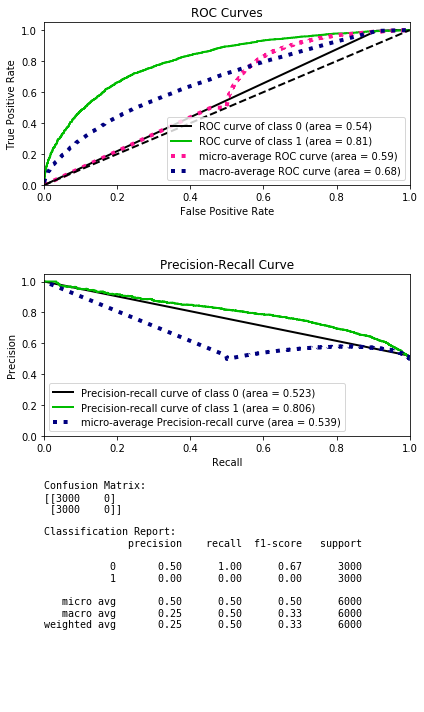

In [104]:
stats_fig, report = benchmark_model_performance(model_logreg, X_test, y_test)
stats_fig.savefig(os.path.join('experiment1-logisticregression.png'), dpi=300, format='png')
stats_fig.show()

### Naive Bayes

In [105]:
# Benchmark Logistic Regression

model_NB = clf_NB.fit(X_train, y_train)

C:\Users\Adam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adam\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


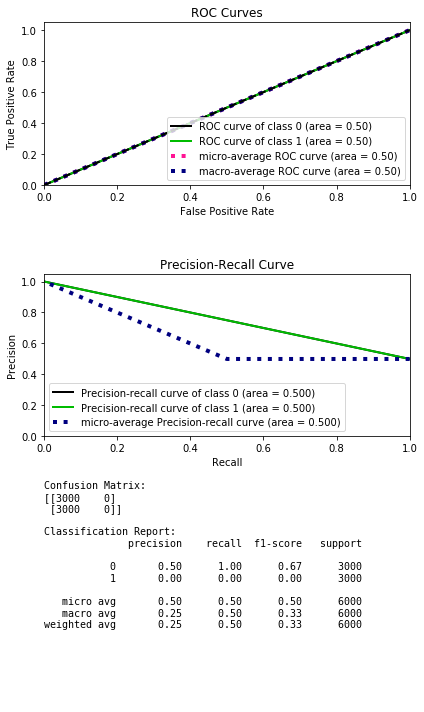

In [106]:
stats_fig, report = benchmark_model_performance(model_NB, X_test, y_test)
stats_fig.savefig(os.path.join('experiment1-naivebayes.png'), dpi=300, format='png')
stats_fig.show()

### XGBoost

In [107]:
# Benchmark Logistic Regression

model_xgb = clf_NB.fit(X_train, y_train)

C:\Users\Adam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adam\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adam\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


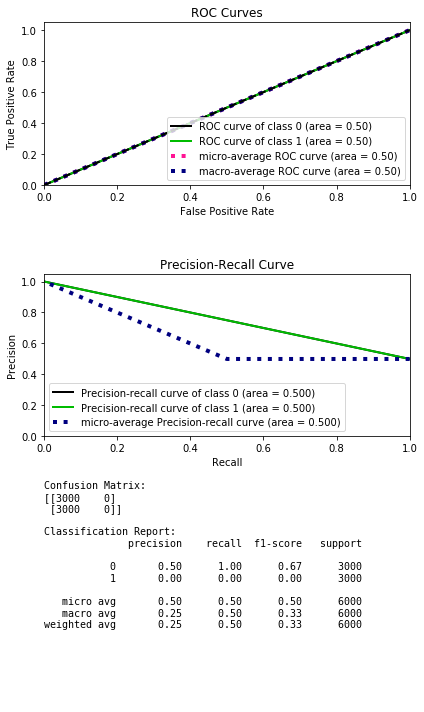

In [108]:
stats_fig, report = benchmark_model_performance(model_xgb, X_test, y_test)
stats_fig.savefig(os.path.join('experiment1-xgb.png'), dpi=300, format='png')
stats_fig.show()

### Light GBM

In [109]:
# Benchmark Logistic Regression

model_lgb = clf_lgb.fit(X_train, y_train)

C:\Users\Adam\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


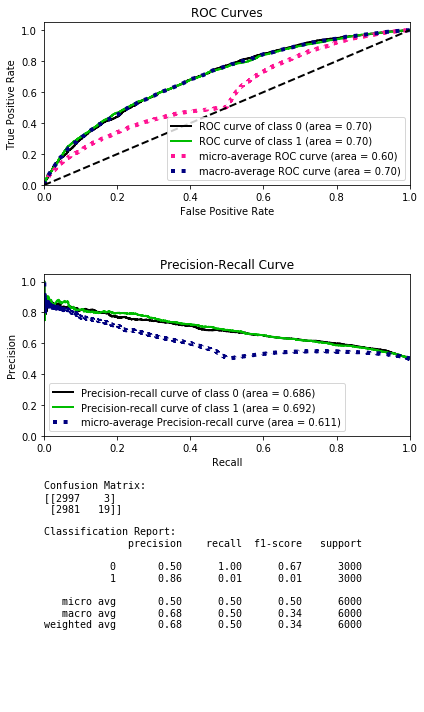

In [110]:
stats_fig, report = benchmark_model_performance(model_lgb, X_test, y_test)
stats_fig.savefig(os.path.join('experiment1-lgb.png'), dpi=300, format='png')
stats_fig.show()